Version of `dimensionality_reduction_experiments.ipynb` using weighted log-loss rather than accuracy as an evaluation metric (`GridSearchCV`'s `scoring` param)

# Setup - imports, load data etc

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer
)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# TODO: increase as necessary for the final model
N_ITERATIONS = 500
TOLERANCE = 1e-3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X = pd.read_csv("drive/MyDrive/COMP9417/X_train.csv").values
y = pd.read_csv("drive/MyDrive/COMP9417/y_train.csv").squeeze()

scaler = StandardScaler()
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
CLASSES = np.unique(y)
# y = label_binarize(y, classes=N_CLASSES) # one-hot encode y
CLASSES

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# X_train, y_train = X, y

In [ ]:
X_train.shape, y_train.shape

((7000, 300), (7000,))

In [ ]:
def weighted_log_loss(y_true, y_pred_proba):
    epsilon = 1e-15
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon) # check
    y_true_ohe = label_binarize(y_true, classes=CLASSES) # check

    class_counts = np.sum(y_true_ohe, axis=0)
    class_weights = 1.0 / class_counts
    class_weights /= np.sum(class_weights)
    print(class_weights.shape) #! debug

    # Classes with no samples should be weighted as 0 (not nan)
    class_weights[np.isnan(class_weights)] = 0

    sample_weights = np.sum(y_true_ohe * class_weights, axis=1)

    # y_pred_proba is in [0, 1], so the mean will be negative. Negate for a positive value
    loss = -np.mean(sample_weights * np.sum(y_true_ohe * np.log(y_pred_proba), axis=1))
    return loss

custom_scorer = make_scorer(weighted_log_loss, response_method="predict_proba", greater_is_better=False)

# Logistic regression + PCA + grid search

In [ ]:
# Basic logistic regression model
logistic = LogisticRegression(
    max_iter=N_ITERATIONS,
    multi_class='multinomial',
    solver='lbfgs',
    # penalty=None,
    tol=TOLERANCE,
    class_weight="balanced", # same as weighted log loss (scaled by some factor)
)

In [ ]:
# Pipeline setup
lr_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("reduce_dim", "passthrough"),
    ("classifier", logistic),
])

In [ ]:
# Grid search with L2 regularization and varying C
C_OPTIONS = np.logspace(-4, 4, 4)
N_FEATURES_OPTIONS = np.geomspace(10, 300, num=10).astype(int)
lr_basic_cv_param_grid = {
        # "reduce_dim": [PCA(iterated_power=7), NMF(max_iter=1_000)],
        "reduce_dim": [PCA()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        # TODO: add more classifiers to grid search
        # TODO: test C separately. Will need to set classifier__penalty &
        "classifier__C": C_OPTIONS,
}
    # TODO: test C separately?
    # TODO: uncomment SelectKBest(mutual_info_classif)
    # TODO: permutation importance..? / other feature selection methods

    #,
    # {
    #     "reduce_dim": [SelectKBest(mutual_info_classif)],
    #     "reduce_dim__k": N_FEATURES_OPTIONS,
    #     "classifier__C": C_OPTIONS,
    # },

In [ ]:
grid = GridSearchCV(
    estimator=lr_pipe,
    param_grid=lr_basic_cv_param_grid,
    scoring=custom_scorer,
    # scoring="f1_macro",
    error_score="raise",
    cv=StratifiedKFold(n_splits=3), # 2/3rds of data for training, 1/3rd for evaluation
    n_jobs=-1
)

grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
wll = weighted_log_loss(y_test, y_proba)

results = {
    "best_params": grid.best_params_,
    "f1": f1,
    "wll": wll,
    "model": grid.best_estimator_,
}

In [ ]:
for k,v in results.items():
  print(k)
  print(v)
  print()

best_params
{'classifier__C': np.float64(0.046415888336127774), 'reduce_dim': PCA(), 'reduce_dim__n_components': np.int64(300)}

f1
0.490598429548289

wll
0.006075077938922576

model
Pipeline(steps=[('scaler', StandardScaler()),
                ('reduce_dim', PCA(n_components=np.int64(300))),
                ('classifier',
                 LogisticRegression(C=np.float64(0.046415888336127774),
                                    class_weight='balanced', max_iter=500,
                                    multi_class='multinomial', tol=0.001))])



In [ ]:
#reducer_labels = ["PCA", "NMF", "KBest(mutual_info_classif)"]

In [ ]:
# grid.cv_results_

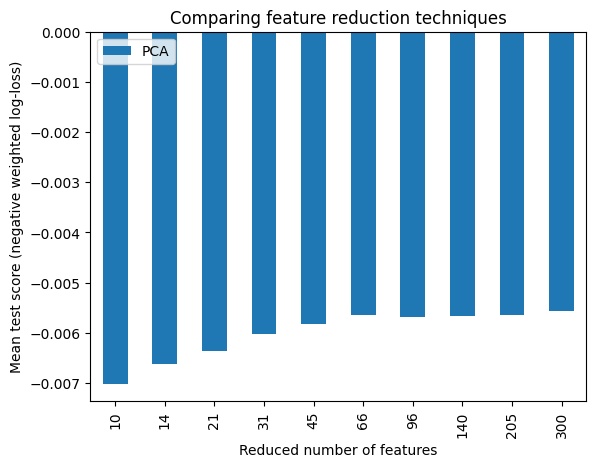

In [ ]:
mean_scores = np.array(grid.cv_results_["mean_test_score"])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)

# create a dataframe to ease plotting
mean_scores = pd.DataFrame(
    mean_scores.T, index=N_FEATURES_OPTIONS, columns=["PCA"]
)

ax = mean_scores.plot.bar()
ax.set_title("Comparing feature reduction techniques")
ax.set_xlabel("Reduced number of features")
# ax.set_ylabel("Mean test score (F1 macro)")
ax.set_ylabel("Mean test score (negative weighted log-loss)")
# ax.set_ylim((0, 1))
ax.legend(loc="upper left")

plt.show()

In [ ]:
# grid.cv_results_["mean_test_score"]
mean_scores

,PCA
10,-0.007016
14,-0.006616
21,-0.006373
31,-0.006024
45,-0.005824
66,-0.005653
96,-0.005685
140,-0.005670
205,-0.005638
300,-0.005565


# Checking weighted log loss for 10 vs 300 features

In [ ]:
# Linear regression + PCA with 10 features selected
lr_pca_10_components = Pipeline(steps=[
    ("scaler", scaler),
    ("reduce_dim", PCA(n_components=10)),
    ("classifier", logistic),
])

lr_pca_10_components.fit(X_train, y_train)
train_pred_proba = lr_pca_10_components.predict_proba(X_train)
print(f"Train WLL (10 feats): {weighted_log_loss(y_train, train_pred_proba):.6f}")

test_pred_proba = lr_pca_10_components.predict_proba(X_test)
print(f"Test WLL (10 feats): {weighted_log_loss(y_test, test_pred_proba):.6f}")

Train WLL (10 feats): 0.005804
Test WLL (10 feats): 0.007741


In [ ]:
# Linear regression + PCA with 10 features selected
lr_pca_300_components = Pipeline(steps=[
    ("scaler", scaler),
    ("reduce_dim", PCA(n_components=300)),
    ("classifier", logistic),
])

lr_pca_300_components.fit(X_train, y_train)
train_pred_proba = lr_pca_300_components.predict_proba(X_train)
print(f"Train WLL (300 feats): {weighted_log_loss(y_train, train_pred_proba):.6f}")

test_pred_proba = lr_pca_300_components.predict_proba(X_test)
print(f"Test WLL (300 feats): {weighted_log_loss(y_test, test_pred_proba):.6f}")

Train WLL (300 feats): 0.000348
Test WLL (300 feats): 0.011544


## And again, with L2 regression & a simple grid search for best C

In [ ]:
# Linear regression + PCA with 10 features selected
lr_pca_10_components = Pipeline(steps=[
    ("scaler", scaler),
    ("reduce_dim", PCA(n_components=10)),
    ("classifier", logistic),
])

lr_pca_10_components = GridSearchCV(
    estimator=lr_pca_10_components,
    param_grid={
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": np.logspace(-4, 4, 4)
    },
    # scoring=custom_scorer,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=3), # 2/3rds of data for training, 1/3rd for evaluation
    n_jobs=-1
)

lr_pca_10_components.fit(X_train, y_train)

train_pred_proba = lr_pca_10_components.predict_proba(X_train)
print(f"Train WLL (10 feats + penalty): {weighted_log_loss(y_train, train_pred_proba):.6f}")

test_pred_proba = lr_pca_10_components.predict_proba(X_test)
print(f"Test WLL (10 feats + penalty): {weighted_log_loss(y_test, test_pred_proba):.6f}")

Train WLL (10 feats + penalty): 0.005805
Test WLL (10 feats + penalty): 0.007734


In [ ]:
# Linear regression + PCA with 10 features selected
lr_pca_300_components = Pipeline(steps=[
    ("scaler", scaler),
    ("reduce_dim", PCA(n_components=300)),
    ("classifier", logistic),
])

lr_pca_300_components = GridSearchCV(
    estimator=lr_pca_300_components,
    param_grid={
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": np.logspace(-4, 4, 4)
    },
    # scoring=custom_scorer,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=3), # 2/3rds of data for training, 1/3rd for evaluation
    n_jobs=-1
)

lr_pca_300_components.fit(X_train, y_train)

train_pred_proba = lr_pca_300_components.predict_proba(X_train)
print(f"Train WLL (300 feats + penalty): {weighted_log_loss(y_train, train_pred_proba):.6f}")

test_pred_proba = lr_pca_300_components.predict_proba(X_test)
print(f"Test WLL (300 feats + penalty): {weighted_log_loss(y_test, test_pred_proba):.6f}")

Train WLL (300 feats + penalty): 0.001044
Test WLL (300 feats + penalty): 0.006075


# Testing more models & dimensionality reduction methods
Assumes the "Setup - imports, load data etc" section has been run.

In [ ]:
# def evaluate_best_per_model(grid, X_train, y_train, X_test, y_test, group_keys):
#     """
#     Evaluate the best models for each combination of values in group_keys.

#     Parameters:
#     - grid: fitted GridSearchCV object
#     - X_train, y_train: train data
#     - X_test, y_test: test data
#     - group_keys: list of keys to group by (e.g. ['param_reduce_dim', 'param_classifier'])

#     Returns:
#     - DataFrame with best scores and classification reports
#     """
#     results_df = pd.DataFrame(grid.cv_results_)
#     print(results_df)

#     # Clean key names
#     for key in group_keys:
#         if key not in results_df:
#             # raise ValueError(f"Missing key {key} in cv_results_")
#             group_keys.remove(key)
#     if not group_keys:
#         raise ValueError(f"Missing key(s) in cv_results_!")

#     # Group and select best by mean_test_score
#     best_rows = results_df.sort_values('mean_test_score', ascending=False).groupby(group_keys).head(1)

#     reports = []

#     for _, row in best_rows.iterrows():
#         params = row['params']
#         model = grid.best_estimator_.set_params(**params)
#         model.fit(X_train, y_train)  # retrain on full train set

#         # TODO: don't use test set until we have our final model?
#         y_pred = model.predict(X_test)
#         y_proba = model.predict_proba(X_test)

#         print(f"\nEvaluating model with: {params}")
#         print(classification_report(y_test, y_pred, zero_division=0))

#         cm = confusion_matrix(y_test, y_pred)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#         disp.plot(xticks_rotation=45)
#         plt.title(f"Confusion Matrix\n{params}")
#         plt.tight_layout()
#         plt.show()

#         reports.append({
#             'params': params,
#             'mean_test_score': row['mean_test_score'],
#             'report': classification_report(y_test, y_pred, output_dict=True)
#         })

#     return pd.DataFrame(reports)

### PCA vs l2 penalty
Note that l2 penalty (regularisation) is considered a filter method of feature selection.

In [ ]:
# Basic logistic regression model
logistic = LogisticRegression(
    max_iter=N_ITERATIONS,
    multi_class='multinomial',
    solver='lbfgs',
    tol=TOLERANCE,
    class_weight="balanced", # same as weighted log loss (scaled by some factor)
)

# Pipeline setup
lr_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("reduce_dim", "passthrough"),
    ("classifier", logistic),
])

# Model 1 - logisitc regression with l2 regularisation only
# It was consistently choosing C=0.0464... when using (-4, 4, 4), shifted the range
C_OPTIONS = np.logspace(-5, 2, 6)
lr_reg_params = {
    "classifier__C": C_OPTIONS,
}

# Model 2 - PCA without regularisation
N_FEATURES_OPTIONS = np.geomspace(10, 300, num=10).astype(int)
lr_pca_params = {
    "reduce_dim": [PCA()],
    "reduce_dim__n_components": N_FEATURES_OPTIONS,
    "classifier__penalty": [None],
}

# Model 3 - Grid search with L2 regularization and varying C
lr_pca_reg_params = {
        "reduce_dim": [PCA()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
        "classifier__C": C_OPTIONS,
}

In [ ]:
from dataclasses import dataclass
from typing import Iterable

@dataclass
class Experiment:
     name: str
     # sklearn classifier, or a pipeline/GridSearchCV etc containing one
     estimator: ...
     param_grid: dict
     # Grid param(s) to group by & use as the horizontal axis, e.g. "classifier__C"
     group_by: str
     trained_model: ... = None

experiments = (
    # Logistic regression (with and without regularisation / PCA etc)
    Experiment('LR - l2 penalty + grid search for C', lr_pipe, lr_reg_params, "classifier__C"),
    Experiment('LR - PCA, no penalty', lr_pipe, lr_pca_params, "reduce_dim__n_components"),
    Experiment('LR - PCA, l2 penalty + grid search for C', lr_pipe, lr_pca_reg_params, "reduce_dim__n_components"),
)

for exp in experiments:
    print(f"Training {exp.name}...")
    grid = GridSearchCV(
        estimator=exp.estimator,
        param_grid=exp.param_grid,
        scoring=custom_scorer, # negative weighted log loss
        error_score="raise", # type: ignore
        cv=StratifiedKFold(n_splits=3), # 2/3rds of data for training, 1/3rd for evaluation
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    exp.trained_model = grid

Training LR - l2 penalty + grid search for C...
Training LR - PCA, no penalty...
Training LR - PCA, l2 penalty + grid search for C...


===== EXPERIMENT: LR - l2 penalty + grid search for C =====

Best params: {'classifier__C': np.float64(0.00630957344480193)}

   mean_cv_wll  classifier__C
0     0.005303       0.006310
1     0.006917       0.000251
2     0.007821       0.158489
3     0.009644       0.000010
4     0.018702       3.981072
5     0.027892     100.000000


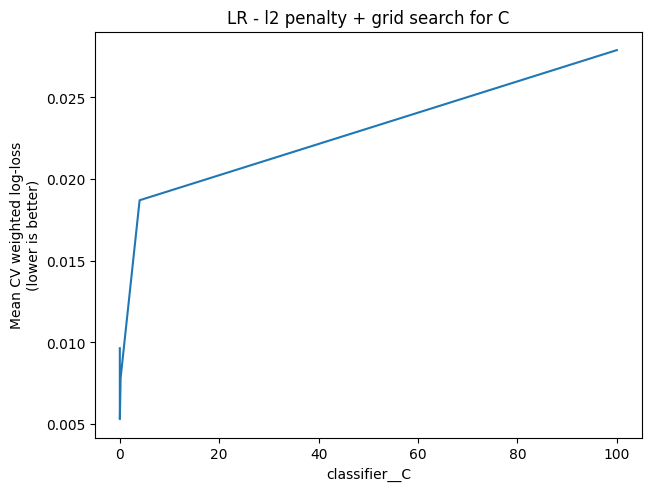


===== EXPERIMENT: LR - PCA, no penalty =====

Best params: {'classifier__penalty': None, 'reduce_dim': PCA(), 'reduce_dim__n_components': np.int64(10)}

   mean_cv_wll  reduce_dim__n_components
0     0.008110                        10
1     0.008948                        14
2     0.009363                        21
3     0.011028                        31
4     0.012688                        45
5     0.016678                        66
6     0.022204                        96
7     0.032038                       140
8     0.035678                       300
9     0.035789                       205


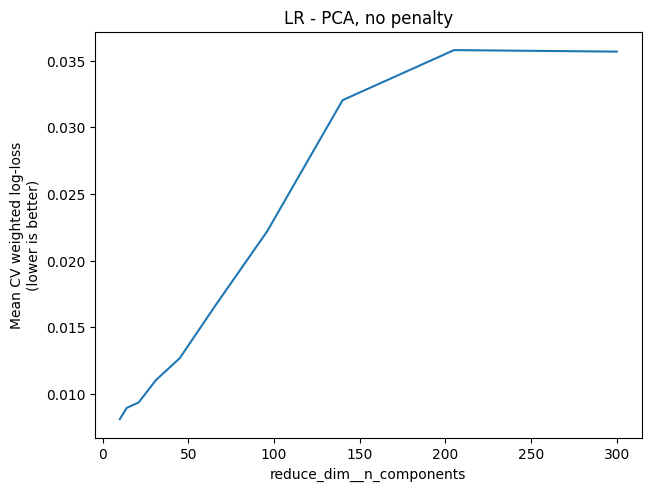


===== EXPERIMENT: LR - PCA, l2 penalty + grid search for C =====

Best params: {'classifier__C': np.float64(0.00630957344480193), 'reduce_dim': PCA(), 'reduce_dim__n_components': np.int64(300)}

   mean_cv_wll  reduce_dim__n_components
0     0.005325                       300
1     0.005334                       205
2     0.005370                       140
3     0.005426                        96
4     0.005574                        66
5     0.005761                        45
6     0.005967                        31
7     0.006227                        21
8     0.006624                        14
9     0.007034                        10


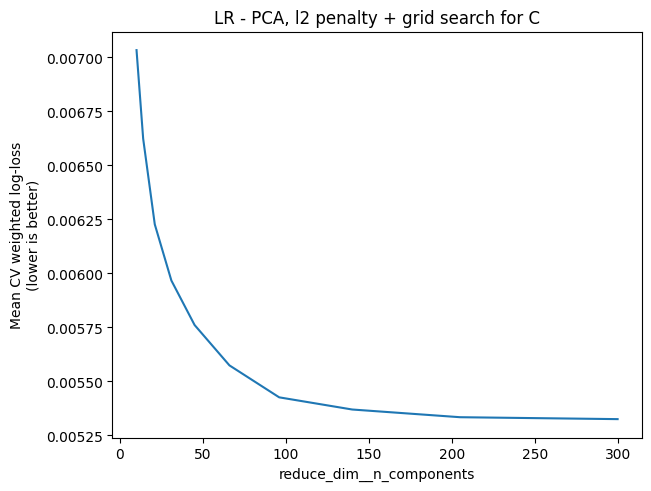

In [ ]:
# all_reports: dict[str, pd.DataFrame] = {}

for exp in experiments:
    # print(exp.name)
    # report = evaluate_best_per_model(grid, X_train, y_train, X_test, y_test, ["param_reduce_dim__n_components", "param_classifier__C"]) # TODO check group keys..?

    grid = exp.trained_model
    if not grid:
        raise AttributeError(f"trained_model not set for {exp.name}")

    results_df = pd.DataFrame(grid.cv_results_)
    # print(results_df)

    # Group and select best by mean_test_score
    # group_by: list[str]
    # match exp.group_by:
    #     case str(param):
    #         group_by = ["param_" + param]
    #     case list(params):
    #         group_by = ["param_" + param for param in params]
    #     case _:
    #         raise AttributeError(f"group_by isn't of type str or list[str] for {exp.name}")

    # group_by = ["param_" + param for param in exp.group_by]
    group_by = "param_" + exp.group_by
    best_rows = results_df.sort_values('mean_test_score', ascending=False).groupby(group_by).head(1)

    reports = []

    for _, row in best_rows.iterrows():
        params = row['params']
        # model = grid.best_estimator_.set_params(**params)
        # model.fit(X_train, y_train)  # retrain on full train set

        # # TODO: don't use test set until we have our final model?
        # y_pred = model.predict(X_test)
        # y_proba = model.predict_proba(X_test)

        # print(f"\nEvaluating model with: {params}")
        # print(classification_report(y_test, y_pred, zero_division=0))

        # cm = confusion_matrix(y_test, y_pred)
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        # disp.plot(xticks_rotation=45)
        # plt.title(f"Confusion Matrix\n{params}")
        # plt.tight_layout()
        # plt.show()

        report = {
            'params': params,
            # 'best_model': model,
            'mean_cv_wll': abs(row['mean_test_score']),
            # 'report': classification_report(y_test, y_pred, output_dict=True)
        }
        report[exp.group_by] = params[exp.group_by]
        reports.append(report)

    # all_reports[exp.name] = pd.DataFrame(reports)
    output_df = pd.DataFrame(reports)

    # Output results
    print(f"===== EXPERIMENT: {exp.name} =====\n")
    best_row = output_df["mean_cv_wll"].idxmin()
    print(f"Best params: {output_df.loc[best_row, 'params']}\n")
    # print(reports[["params", "mean_cv_test_score"]])
    print(output_df.loc[:, output_df.columns != "params"])
    # print("\n====================\n")

    plt.figure(constrained_layout=True)
    ax = sns.lineplot(data=output_df, x=exp.group_by, y="mean_cv_wll")
    plt.title(exp.name)
    ax.set_ylabel("Mean CV weighted log-loss\n(lower is better)")
    plt.show()
    print()

    # TODO: print classification report / confusion matrix for best model (`grid`)


In [ ]:
# pd.set_option('display.max_colwidth', None)

# for experiment_name, reports in all_reports.items():
    # print(f"EXPERIMENT: {experiment_name}\n")
    # best_row = reports["mean_cv_wll"].idxmin()
    # print(best_row)
    # print(f"Best params: {reports.loc[best_row, 'params']}\n")
    # # print(reports[["params", "mean_cv_test_score"]])
    # print(reports.loc[:, reports.columns != "params"])

    # sns.lineplot(data=reports, x="x", y="mean_cv_wll")
    # print("\n====================\n")

# pd.set_option('display.max_colwidth', 50)

## SelectKBest(mutual_info_classif)
TODO: update variable/experiment names

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Basic logistic regression model
logistic = LogisticRegression(
    max_iter=N_ITERATIONS,
    multi_class='multinomial',
    solver='lbfgs',
    tol=TOLERANCE,
    class_weight="balanced", # same as weighted log loss (scaled by some factor)
)

# Pipeline setup
lr_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("pca", PCA(0.95)),
    ("feat_select", "passthrough"),
    ("classifier", logistic),
])

# Model 1 - logistic regression with l2 regularisation only
# It was consistently choosing C=0.0464... when using (-4, 4, 4), shifted the range
C_OPTIONS = np.logspace(-5, 2, 6)
lr_reg_params = {
    "classifier__C": C_OPTIONS,
}

# Model 2 - select k best without regularisation
# N_FEATURES_OPTIONS = np.geomspace(10, 300, num=10).astype(int)
N_FEATURES_OPTIONS = [10, 50, 100]
lr_pca_params = {
    "feat_select": [SelectKBest(score_func=mutual_info_classif)],
    "feat_select__k": N_FEATURES_OPTIONS, # TODO - diff n components?
    "classifier__penalty": [None],
}

# Model 3 - Grid search with L2 regularization and varying C
lr_pca_reg_params = {
    "feat_select": [SelectKBest(score_func=mutual_info_classif)],
    "feat_select__k": N_FEATURES_OPTIONS, # TODO - diff n components?
    "classifier__C": C_OPTIONS,
}

In [ ]:
from dataclasses import dataclass
from typing import Iterable

@dataclass
class Experiment:
     name: str
     # sklearn classifier, or a pipeline/GridSearchCV etc containing one
     estimator: ...
     param_grid: dict
     # Grid param(s) to group by & use as the horizontal axis, e.g. "classifier__C"
     group_by: str
     trained_model: ... = None

experiments = (
    # Logistic regression (with and without regularisation / PCA etc)
    Experiment('LR - l2 penalty + grid search for C', lr_pipe, lr_reg_params, "classifier__C"),
    Experiment('LR - PCA, no penalty', lr_pipe, lr_pca_params, "reduce_dim__n_components"),
    Experiment('LR - PCA, l2 penalty + grid search for C', lr_pipe, lr_pca_reg_params, "reduce_dim__n_components"),
)

for exp in experiments:
    print(f"Training {exp.name}...")
    grid = GridSearchCV(
        estimator=exp.estimator,
        param_grid=exp.param_grid,
        scoring=custom_scorer, # negative weighted log loss
        error_score="raise", # type: ignore
        cv=StratifiedKFold(n_splits=3), # 2/3rds of data for training, 1/3rd for evaluation
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    exp.trained_model = grid

Training LR - l2 penalty + grid search for C...
Training LR - PCA, no penalty...


In [ ]:
for exp in experiments:
    grid = exp.trained_model
    if not grid:
        raise AttributeError(f"trained_model not set for {exp.name}")

    results_df = pd.DataFrame(grid.cv_results_)

    group_by = "param_" + exp.group_by
    best_rows = results_df.sort_values('mean_test_score', ascending=False).groupby(group_by).head(1)

    reports = []

    for _, row in best_rows.iterrows():
        params = row['params']

        report = {
            'params': params,
            'mean_cv_wll': abs(row['mean_test_score']),
        }
        report[exp.group_by] = params[exp.group_by]
        reports.append(report)

    output_df = pd.DataFrame(reports)

    # Output results
    print(f"===== EXPERIMENT: {exp.name} =====\n")
    best_row = output_df["mean_cv_wll"].idxmin()
    print(f"Best params: {output_df.loc[best_row, 'params']}\n")
    print(output_df.loc[:, output_df.columns != "params"])

    plt.figure(constrained_layout=True)
    ax = sns.lineplot(data=output_df, x=exp.group_by, y="mean_cv_wll")
    plt.title(exp.name)
    ax.set_ylabel("Mean CV weighted log-loss\n(lower is better)")
    plt.show()
    print()

    # TODO: print classification report / confusion matrix for best model (`grid`)


# TODO: check N_COMPONENTS=0.8, 0.85, 0.9, 0.95, (1?)

For e.g. 95% of explained variance in X